In [ ]:
'''
1. Import Packages
2. Import Data
3. Preproccess Data Frame:
    1. Remove rows that have N/A values in Market Category Column
    2. Convert 'Make', 'Market Category', 'Vehicle Size', 'Vehicle Style' 
       into Numerical Enumerations
    3. Normalize data (improves accuracy for calculating distance/Euclidean Distance)
4.  Run DBSCAN for 6 Dimensional feature set for 'Make', 'Year', 'Market Category', 'Vehicle Size', 'Vehicle Style', 'MSRP'
5. Visualize/Plot Clusters
'''

In [1]:
# Import Packages
import numpy as np
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import csv
import pandas as pd
%matplotlib inline

In [2]:
# Import Data
car_df = pd.read_csv('car_data.csv')
car_df.head(5)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [3]:
'''Preprocess Data'''

# Remove Spaces in Column Names
car_df = car_df.rename(columns={"Market Category": "Market_Category", "Vehicle Size": "Vehicle_Size", "Vehicle Style": "Vehicle_Style" })

# Drop rows where there are
car_df.drop(car_df.index[car_df['Market_Category'] == 'N/A'], inplace=True)
# car_df = car_df[car_df.Market_Category != 'N/A']

In [6]:
# Convert Categorical columns to numeric
M_List = car_df.Make.unique()
MK_List = car_df.Market_Category.unique()
VZ_List = car_df.Vehicle_Size.unique()
VS_List = car_df.Vehicle_Style.unique()

car_df.Make = car_df['Make'].replace(M_List, range(len(M_List)))
car_df.Market_Category = car_df['Market_Category'].replace(MK_List, range(len(MK_List)))
car_df.Vehicle_Size = car_df['Vehicle_Size'].replace(VZ_List, range(len(VZ_List)))
car_df.Vehicle_Style = car_df['Vehicle_Style'].replace(VS_List, range(len(VS_List)))

# alternatively could use pd.get_dummies() which will create a seperate column for each unique category, but to reduce dimension size we use replace method

In [8]:
# Reset index for dropped rows
car_df = car_df.reset_index(drop=True)

In [9]:
# Normalize Data
predictors = car_df[['Make', 'Year', 'Market_Category', 'Vehicle_Size', 'Vehicle_Style']].values

predictors = preprocessing.StandardScaler().fit(predictors).transform(predictors.astype(float))
predictors[0:3]

array([[-1.77192037,  0.08122813, -1.02199787, -1.07110811, -1.30207652],
       [-1.77192037,  0.08122813, -0.93462644, -1.07110811, -1.01762854],
       [-1.77192037,  0.08122813, -0.84725501, -1.07110811, -1.30207652]])

In [10]:
# Build Model

# Random state ensures that the splits that you generate are reproducible
sklearn.utils.check_random_state(1000)

DB_Model = DBSCAN(eps=0.3, min_samples=10).fit(predictors)

# Create new column in dataframe to hold our target cluster labels
clusters = DB_Model.labels_
car_df["Cluster"] = clusters

# ignore noise (-1) in our cluster count
numOfClusters = len(set(clusters)) - (1 if -1 in clusters else 0)


car_df[['Make', 'Year', 'Market_Category', 'Vehicle_Size', 'Vehicle_Style', 'Cluster']].head(5)

,Make,Year,Market_Category,Vehicle_Size,Vehicle_Style,Cluster
0,0,2011,0,0,0,0
1,0,2011,1,0,1,0
2,0,2011,2,0,0,0
3,0,2011,1,0,0,0
4,0,2011,3,0,1,0


In [44]:
# Save Model
import joblib

# pickle files serialize your ML algorithiim and save them in a serialized format to a file
# save
# joblib.dump(DB_Model, "Car_Cluster.pkl")

# using the joblib libray, you can deserialize pickle files to load your model
# load
# model = joblib.load("Car_Cluster.pkl")

# model.predict(X[0:1])

['Car_Cluster.pkl']

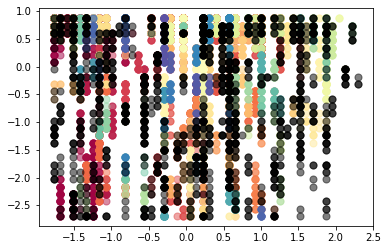

In [11]:
# Visualize Data

# create colors for each cluster
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(clusters))))

# create an array of booleans using the labels from the model. This determines which data points belong to a cluster or outlier
core_samples_mask = np.zeros_like(DB_Model.labels_, dtype=bool)
core_samples_mask[DB_Model.core_sample_indices_] = True

# Plot the points with colors
for k, col in zip(set(clusters), colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
    
    # create a mask for the cluster group corresponding to k (cluster label)
    class_member_mask = (clusters == k)

    # Plot the datapoints that are clustered
    xy = predictors[class_member_mask & core_samples_mask] # get our predictors where there is a member of the current cluster AND the data point belongs to a cluster
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

    # Plot the outliers
    xy = predictors[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

In [12]:
len(set(clusters))

237

In [16]:
# Determine Accuarcy with Silhouette Coefficient
from sklearn import metrics
metrics.silhouette_score(car_df[['Make', 'Year', 'Market_Category', 'Vehicle_Size', 'Vehicle_Style', 'Cluster']], car_df["Cluster"])

0.4227129780062382

In [17]:
# Adjust Minimum Samples based on dimensionality 2*dim
minPts = 2 * 5

In [18]:
# Adjust Epsilon
from sklearn.neighbors import NearestNeighbors

# To determine the best epsilon value, we calculate the average distance between each point and its closest/nearest neighbors, We then plot a k-distance and choose the epsilon value at the “elbow” of the graph
dataSet = car_df[['Make', 'Year', 'Market_Category', 'Vehicle_Size', 'Vehicle_Style']]
neighbors = NearestNeighbors(n_neighbors=minPts) # creates model to implement neighbor searches
neighbors_fit = neighbors.fit(dataSet) # fit our model using our data
distances, indices = neighbors_fit.kneighbors(dataSet) # return array of average distances of k-neighbors of each point in dataset

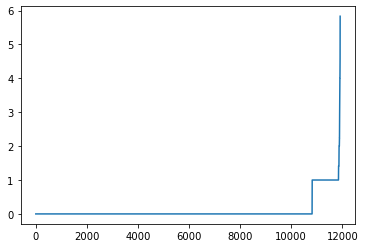

In [20]:
# Sort and plot average distances to find best epsilon
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [28]:
# Build Model

# Random state ensures that the splits that you generate are reproducible
sklearn.utils.check_random_state(1000)

def buildModel(e,minpts):
    car_df2 = car_df # make a copy
    
    DB_Model = DBSCAN(eps=e, min_samples=minpts).fit(predictors)

    # Create new column in dataframe to hold our target cluster labels
    clusters = DB_Model.labels_
    car_df2["Cluster"] = clusters

    # ignore noise (-1) in our cluster count
    numOfClusters = len(set(clusters)) - (1 if -1 in clusters else 0)

    return DB_Model, clusters, car_df2

In [30]:
# Visualize Data

def plotClusters(DB_Model, clusters):
    # create colors for each cluster
    colors = plt.cm.Spectral(np.linspace(0, 1, len(set(clusters))))

    # create an array of booleans using the labels from the model. This determines which data points belong to a cluster or outlier
    core_samples_mask = np.zeros_like(DB_Model.labels_, dtype=bool)
    core_samples_mask[DB_Model.core_sample_indices_] = True

    # Plot the points with colors
    for k, col in zip(set(clusters), colors):
        if k == -1:
            # Black used for noise.
            col = 'k'
    
        # create a mask for the cluster group corresponding to k (cluster label)
        class_member_mask = (clusters == k)

        # Plot the datapoints that are clustered
        xy = predictors[class_member_mask & core_samples_mask] # get our predictors where there is a member of the current cluster AND the data point belongs to a cluster
        plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

        # Plot the outliers
        xy = predictors[class_member_mask & ~core_samples_mask]
        plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

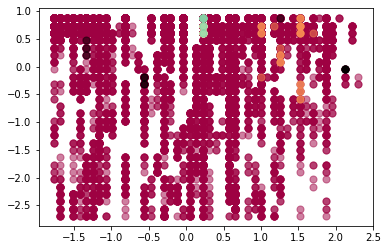

In [31]:
# Try again with optimal epsilon and minPts
db_model, clusters, car_df2 = buildModel(1.3,minPts)
plotClusters(db_model, clusters)

In [32]:
len(set(clusters))

5

In [ ]:
# Get Accuarcy
metrics.silhouette_score(car_df2[['Make', 'Year', 'Market_Category', 'Vehicle_Size', 'Vehicle_Style', 'Cluster']], car_df2["Cluster"])